<a href="https://www.kaggle.com/code/siddp6/mountain-landscape-generative-adversarial-networks?scriptVersionId=178361008" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Imports

In [1]:
import torch
import os
import shutil

import torchvision.transforms as T # for modifying the image. 
import matplotlib.pyplot as plt # for plotting images
import torch.nn as nn # for convolutional neural network
import torch.nn.functional as F # for loss function

from torch.utils.data import Dataset, DataLoader # for creating dataset and loading them to model.
from PIL import Image # for veiwing the image
from torchvision.utils import make_grid # for making image grid
from tqdm.notebook import tqdm # for progress bar
from torchvision.utils import save_image # to save images

## Data

In [2]:
data_path = "/kaggle/input/intel-image-classification/seg_train/seg_train/mountain"

- Neural networks generally perform better with input data that ranges around 0 and has a small, uniform scale. 
- By normalizing the images, the pixel values (originally ranging from 0 to 255) are typically scaled to a range such as -1 to 1 (if using a mean of 0.5 and standard deviation of 0.5). 
- This helps in speeding up the convergence during training because it ensures that the input features (pixel values) are on a similar scale, aiding the optimization algorithms to work more efficiently.


In [3]:
# Define the size of the images, higher value means higher quality
image_size = 256

"""
The stats tuple (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), represents the means and standard deviations for each 
of the three color channels (red, green, blue) used to normalize the images. 
"""

stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

# Define the batch size for data loading
batch_size = 64

# Define the transformations to be applied to the images
transformer = T.Compose([
    T.Resize(image_size),               # Resize the image to the specified size
    T.CenterCrop(image_size),           # Crop the center of the image to the specified size
    T.RandomHorizontalFlip(0.5),        # Randomly flip the image horizontally with a probability of 0.5
    T.ToTensor(),                       # Convert the image to a PyTorch tensor
    T.Normalize(*stats)                 # Normalize the tensor using the specified mean and std deviation
])

In [4]:
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Initializes the dataset object.
        
        Args:
            root_dir (str): Directory containing the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir  # Path to the directory where images are stored
        self.transform = transform  # Transformations to be applied to the images
        # List all images in root_dir that end with png, jpg, or jpeg
        self.images = [os.path.join(root_dir, img) for img in os.listdir(root_dir) if img.endswith(('png', 'jpg', 'jpeg'))]

    def __len__(self):
        """
        Returns the total number of images in the dataset.
        """
        return len(self.images)

    def __getitem__(self, idx):
        """
        Retrieves an image from the dataset at the specified index.

        Args:
            idx (int): Index of the image to retrieve.
        
        Returns:
            image (PIL.Image): The image at the specified index after applying transformations.
        """
        img_path = self.images[idx]  # Get the image path
        image = Image.open(img_path).convert('RGB')  # Open the image and convert it to RGB
        if self.transform:
            image = self.transform(image)  # Apply transformations, if any
        return image

In [5]:
# Create an instance of CustomImageDataset with specified path and transformations
dataset = CustomImageDataset(data_path, transform=transformer)
# DataLoader to handle batching and loading of the dataset
dataset_loader = DataLoader(
    dataset,                 # The dataset to load
    batch_size,              # Number of images in each batch
    shuffle=True,            # Shuffle the data to randomize the order of images
    num_workers=4,           # Number of subprocesses to use for data loading
    pin_memory=True          # If True, the DataLoader will copy tensors into CUDA pinned memory before returning them
)

- The pin_memory option in PyTorch's DataLoader is used to enable faster transfers of data from host (CPU) memory to GPU memory, which can lead to performance improvements during training deep learning models.

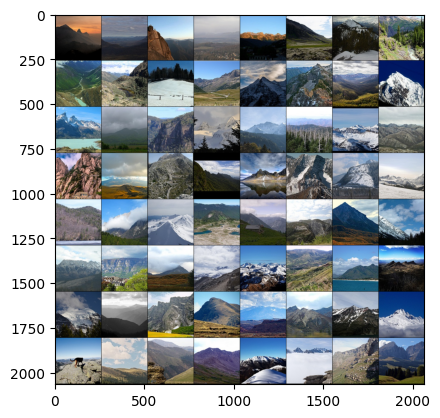

In [6]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    plt.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl):
    for images in dl:
        show_images(images)
        break
        
show_batch(dataset_loader)

## Discriminator and Generator

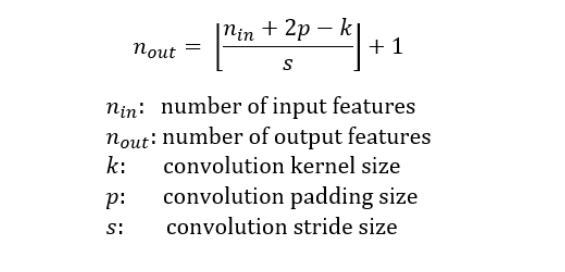

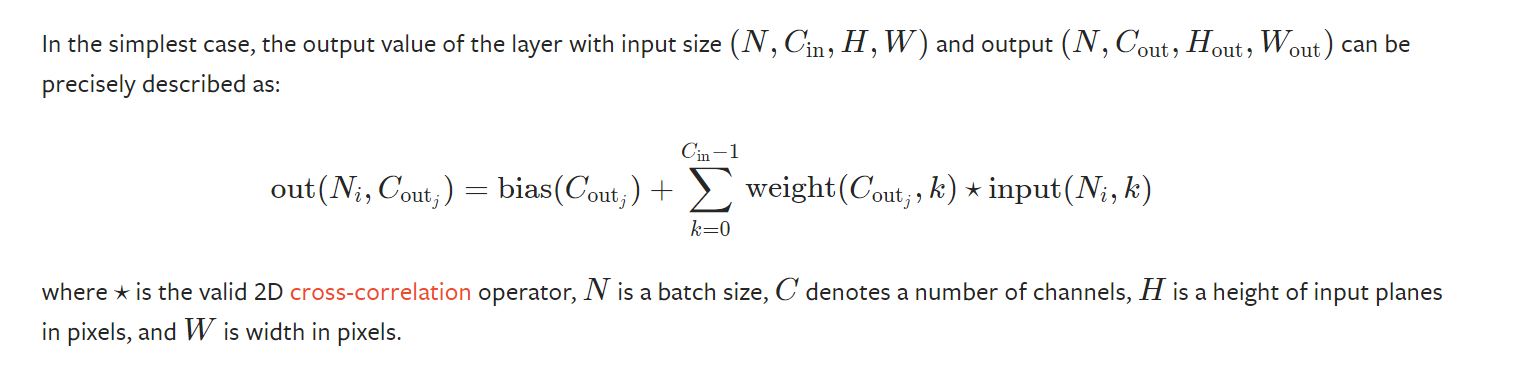


In [7]:
discriminator = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
    # Input: 256x256, Output: (256 - 4 + 2*1) / 2 + 1 = 128x128
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    # Input: 128x128, Output: (128 - 4 + 2*1) / 2 + 1 = 64x64
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    # Input: 64x64, Output: (64 - 4 + 2*1) / 2 + 1 = 32x32
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    # Input: 32x32, Output: (32 - 4 + 2*1) / 2 + 1 = 16x16
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False),
    # Input: 16x16, Output: (16 - 4 + 2*1) / 2 + 1 = 8x8
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False),
    # Input: 8x8, Output: (8 - 4 + 2*1) / 2 + 1 = 4x4
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # Input: 4x4, Output: (4 - 4 + 0*0) / 1 + 1 = 1x1

    nn.Flatten(),
    nn.Sigmoid()
)

In [8]:
latent_size = 512

generator = nn.Sequential(
    nn.ConvTranspose2d(in_channels=latent_size, out_channels=1024, kernel_size=4, stride=1, padding=0, bias=False),
    # Input: 1x1, Output: (1 - 1)*1 - 2*0 + 4 = 4x4
    nn.BatchNorm2d(1024),
    nn.ReLU(True),

    nn.ConvTranspose2d(1024, 1024, kernel_size=4, stride=2, padding=1, bias=False),
    # Input: 4x4, Output: (4 - 1)*2 - 2*1 + 4 = 8x8
    nn.BatchNorm2d(1024),
    nn.ReLU(True),

    nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
    # Input: 8x8, Output: (8 - 1)*2 - 2*1 + 4 = 16x16
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    # Input: 16x16, Output: (16 - 1)*2 - 2*1 + 4 = 32x32
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    # Input: 32x32, Output: (32 - 1)*2 - 2*1 + 4 = 64x64
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    # Input: 64x64, Output: (64 - 1)*2 - 2*1 + 4 = 128x128
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
    # Input: 128x128, Output: (128 - 1)*2 - 2*1 + 4 = 256x256
    nn.BatchNorm2d(32),
    nn.ReLU(True),

    nn.ConvTranspose2d(32, 3, kernel_size=3, stride=1, padding=1, bias=False),
    # Input: 256x256, Output: (256 - 1)*1 - 2*1 + 3 = 256x256
    nn.Tanh()  # Normalize output to [-1, 1]
)

## Set GPU

In [9]:
def get_device():
    """
    Determines the best available device for computations (CPU or GPU).
    
    Returns:
        torch.device: The device ('cuda' or 'cpu') where tensors should be allocated.
    """
    if torch.cuda.is_available():
        return torch.device('cuda')  # Return a GPU device if CUDA is available
    else:
        return torch.device('cpu')   # Return CPU if CUDA is not available

def to_device(data, device):
    """
    Recursively moves tensors to the specified device.
    
    Args:
        data (tensor, list, tuple): Data to be moved to the device.
        device (torch.device): The device to move data to.
        
    Returns:
        Tensor or list of tensors moved to the specified device.
    """
    if isinstance(data, (list, tuple)):
        # Recursively move each item to the device if data is a list or tuple
        return [to_device(x, device) for x in data]
    else:
        # Move tensor to device asynchronously for performance
        return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """
    A wrapper around DataLoader to automatically move data to a device during iteration.
    """
    def __init__(self, dl, device):
        """
        Initializes the DeviceDataLoader.
        
        Args:
            dl (DataLoader): The DataLoader whose batches will be moved to the device.
            device (torch.device): The device to move data to.
        """
        self.dl = dl      # The DataLoader to wrap
        self.device = device  # The device to move data to

    def __iter__(self):
        """
        Yield a batch of data after moving it to the specified device.
        """
        for data in self.dl:
            yield to_device(data, self.device)  # Move each batch to device before yielding

    def __len__(self):
        """
        Returns the number of batches available in the DataLoader.
        """
        return len(self.dl)  # Return the length of the underlying DataLoader

In [10]:
device = get_device()

dataset_loader = DeviceDataLoader(dataset_loader, device)
print(f"Train loader device: {next(iter(dataset_loader))[0].device}")

discriminator = to_device(discriminator, device)
print(f"Discriminator device: {next(discriminator.parameters()).device}")

generator = to_device(generator, device)
print(f"Generator device: {next(generator.parameters()).device}")

Train loader device: cuda:0
Discriminator device: cuda:0
Generator device: cuda:0


## Training

torch.Size([64, 512, 1, 1])
torch.Size([64, 3, 256, 256])


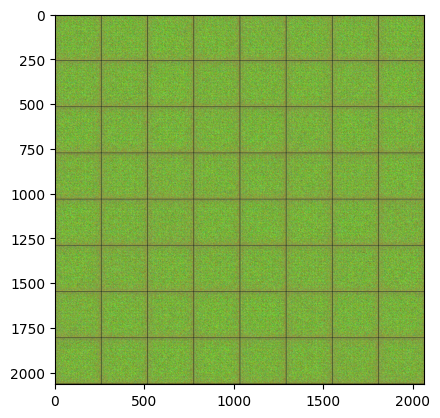

In [11]:
xb = torch.randn(batch_size, 512, 1, 1) # random latent tensors
xb = to_device(xb, device)
fake_images = generator(xb)
print(xb.shape)
print(fake_images.shape)
fake_images_cpu = fake_images.cpu()  # Move the tensor to CPU
show_images(fake_images_cpu)

In [12]:
def train_discriminator(real_images, opt_d):
    """
    Trains the discriminator network with both real and fake images.
    
    Args:
        real_images (torch.Tensor): A batch of real images.
        opt_d (torch.optim.Optimizer): The optimizer for the discriminator.
    
    Returns:
        tuple: Contains the total loss, mean probability score assigned to real images, 
               and mean probability score assigned to fake images.
    """
    # Clear previous gradients; important for correct gradient accumulation
    opt_d.zero_grad()

    # Forward pass real images through the discriminator to compute the loss on real images
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)  # Targets for real images
    real_loss = F.binary_cross_entropy(real_preds, real_targets)  # Compute BCE loss
    real_score = torch.mean(real_preds).item()  # Calculate the mean of the discriminator outputs for real images

    # Generate fake images from noise
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)  # Sample random latent vector
    fake_images = generator(latent)  # Generate fake images using the generator

    # Forward pass fake images through the discriminator to compute the loss on fake images
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)  # Targets for fake images
    fake_preds = discriminator(fake_images)  # Discriminator predictions for fake images
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)  # Compute BCE loss
    fake_score = torch.mean(fake_preds).item()  # Calculate the mean of the discriminator outputs for fake images

    # Combine losses and perform a backward pass to update the discriminator
    loss = real_loss + fake_loss  # Total loss for the discriminator
    loss.backward()  # Backpropagation
    opt_d.step()  # Update discriminator weights

    return loss.item(), real_score, fake_score  # Return the total loss and discriminator scores for real and fake images


In [13]:
def train_generator(opt_g):
    """
    Trains the generator network to improve its ability to generate realistic images.
    
    Args:
        opt_g (torch.optim.Optimizer): The optimizer for the generator.
    
    Returns:
        float: The loss value indicating how well the generator is fooling the discriminator.
    """
    # Clear previous gradients from the optimizer, necessary for correct gradient computation
    opt_g.zero_grad()

    # Generate a batch of fake images using random noise as input
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)  # Random noise vector
    fake_images = generator(latent)  # Generate fake images from noise

    # Forward pass fake images through the discriminator
    preds = discriminator(fake_images)  # Discriminator's predictions on the fake images
    targets = torch.ones(batch_size, 1, device=device)  # Set targets as 1, representing 'real'
    loss = F.binary_cross_entropy(preds, targets)  # Compute loss to fool the discriminator

    # Perform a backward pass to compute gradients
    loss.backward()  # Backpropagate to compute gradients
    opt_g.step()  # Update generator weights based on gradients

    return loss.item()  # Return the computed loss value

In [14]:
fixed_latent = torch.randn(128, latent_size, 1, 1, device=device)

In [15]:
sample_dir = 'generated_images'
if os.path.exists(sample_dir):
    shutil.rmtree(sample_dir)
os.makedirs(sample_dir, exist_ok=True)

def save_samples(index, latent_tensors, save_all, show):
    fake_images = generator(latent_tensors)
    denorm_images = denorm(fake_images)

    if save_all:
        folder_name = 'batch-{0:0=4d}'.format(index)
        os.makedirs(os.path.join(sample_dir, folder_name), exist_ok=True)
        for i, image in enumerate(denorm_images):  # Loop through each image
            fake_fname = 'generated-image-{0:0=4d}.jpg'.format(i)  # Use index for filename
            save_image(image, os.path.join(sample_dir, folder_name, fake_fname))
    else:
        fig, ax = plt.subplots(figsize=(8, 8))
        plt.imshow(make_grid(denorm_images.cpu().detach(), nrow=8).permute(1, 2, 0))


In [16]:
def fit(epochs, lr, start_idx=1):
    """
    Trains both the generator and discriminator networks over a specified number of epochs.
    
    Args:
        epochs (int): Total number of epochs to train.
        lr (float): Learning rate for the optimizers.
        start_idx (int): Starting index for saving generated samples.
    
    Returns:
        tuple: Lists containing the losses for the generator and discriminator, and scores for real and fake images.
    """
    torch.cuda.empty_cache()  # Clear GPU cache to free up unused memory and avoid CUDA errors

    # Initialize lists to store losses and scores for analysis
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Setup the optimizers for both networks with Adam optimizer
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    # Loop over the dataset for a given number of epochs
    for epoch in range(epochs):
        for real_images in tqdm(dataset_loader, desc=f'Epoch {epoch+1}/{epochs}'):
            # Train the discriminator on real and generated fake images
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train the generator to improve at fooling the discriminator
            loss_g = train_generator(opt_g)

        # Save the losses and scores for this epoch
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Output the training progress
        print(f"Epoch [{epoch+1}/{epochs}], loss_g: {loss_g:.4f}, loss_d: {loss_d:.4f}, real_score: {real_score:.4f}, fake_score: {fake_score:.4f}")

        # Save generated images every 10 epochs and at the last epoch
        if epoch % 100 == 0 or epoch == epochs - 1:
            save_samples(epoch + start_idx, fixed_latent, show=True, save_all = False)  # Save sample images
        if epoch == epochs - 1 or epoch == 0:
            save_samples(epoch + start_idx, fixed_latent, show=True, save_all = True)  # Save sample images
            
    return losses_g, losses_d, real_scores, fake_scores

Epoch 1/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1/200], loss_g: 1.1238, loss_d: 4.0438, real_score: 0.1001, fake_score: 0.0028


Epoch 2/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [2/200], loss_g: 7.7239, loss_d: 0.3225, real_score: 0.9091, fake_score: 0.1456


Epoch 3/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [3/200], loss_g: 5.5813, loss_d: 0.2561, real_score: 0.9338, fake_score: 0.0188


Epoch 4/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [4/200], loss_g: 11.5536, loss_d: 8.7418, real_score: 0.9353, fake_score: 0.9275


Epoch 5/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [5/200], loss_g: 8.0877, loss_d: 0.0568, real_score: 0.9583, fake_score: 0.0005


Epoch 6/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [6/200], loss_g: 5.3660, loss_d: 0.0156, real_score: 0.9984, fake_score: 0.0139


Epoch 7/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [7/200], loss_g: 11.3842, loss_d: 0.0018, real_score: 0.9985, fake_score: 0.0003


Epoch 8/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [8/200], loss_g: 5.8788, loss_d: 0.0040, real_score: 0.9985, fake_score: 0.0025


Epoch 9/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [9/200], loss_g: 4.5869, loss_d: 0.0121, real_score: 0.9992, fake_score: 0.0113


Epoch 10/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [10/200], loss_g: 10.6694, loss_d: 0.0190, real_score: 1.0000, fake_score: 0.0188


Epoch 11/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [11/200], loss_g: 4.9988, loss_d: 0.0029, real_score: 0.9998, fake_score: 0.0027


Epoch 12/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [12/200], loss_g: 6.3583, loss_d: 0.0033, real_score: 0.9999, fake_score: 0.0032


Epoch 13/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [13/200], loss_g: 5.7847, loss_d: 0.0037, real_score: 0.9988, fake_score: 0.0025


Epoch 14/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [14/200], loss_g: 6.0165, loss_d: 0.0003, real_score: 1.0000, fake_score: 0.0003


Epoch 15/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [15/200], loss_g: 0.8384, loss_d: 4.6901, real_score: 0.4339, fake_score: 0.0799


Epoch 16/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [16/200], loss_g: 9.0820, loss_d: 1.0758, real_score: 0.9335, fake_score: 0.3300


Epoch 17/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [17/200], loss_g: 3.5988, loss_d: 0.2940, real_score: 0.8941, fake_score: 0.1192


Epoch 18/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [18/200], loss_g: 2.5864, loss_d: 1.6025, real_score: 0.8694, fake_score: 0.6644


Epoch 19/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [19/200], loss_g: 0.7815, loss_d: 2.5921, real_score: 0.1573, fake_score: 0.0448


Epoch 20/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [20/200], loss_g: 2.0470, loss_d: 1.8208, real_score: 0.8538, fake_score: 0.7437


Epoch 21/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [21/200], loss_g: 1.2003, loss_d: 1.3360, real_score: 0.3657, fake_score: 0.1728


Epoch 22/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [22/200], loss_g: 1.5936, loss_d: 1.3536, real_score: 0.6594, fake_score: 0.5584


Epoch 23/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [23/200], loss_g: 1.6244, loss_d: 1.0205, real_score: 0.5865, fake_score: 0.3214


Epoch 24/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [24/200], loss_g: 2.4987, loss_d: 1.1574, real_score: 0.6653, fake_score: 0.4733


Epoch 25/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [25/200], loss_g: 0.7624, loss_d: 1.1607, real_score: 0.4959, fake_score: 0.2624


Epoch 26/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [26/200], loss_g: 4.0262, loss_d: 1.3979, real_score: 0.8245, fake_score: 0.6435


Epoch 27/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [27/200], loss_g: 1.9478, loss_d: 1.0011, real_score: 0.7078, fake_score: 0.4272


Epoch 28/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [28/200], loss_g: 3.2706, loss_d: 1.2327, real_score: 0.5904, fake_score: 0.4631


Epoch 29/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [29/200], loss_g: 2.6202, loss_d: 0.7454, real_score: 0.5831, fake_score: 0.0594


Epoch 30/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [30/200], loss_g: 2.6651, loss_d: 2.2601, real_score: 0.8350, fake_score: 0.7763


Epoch 31/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [31/200], loss_g: 2.0097, loss_d: 0.9385, real_score: 0.6313, fake_score: 0.2947


Epoch 32/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [32/200], loss_g: 4.2363, loss_d: 0.9722, real_score: 0.8647, fake_score: 0.5186


Epoch 33/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [33/200], loss_g: 2.3859, loss_d: 0.8170, real_score: 0.7823, fake_score: 0.4127


Epoch 34/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [34/200], loss_g: 2.0792, loss_d: 0.8330, real_score: 0.5437, fake_score: 0.0954


Epoch 35/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [35/200], loss_g: 2.2435, loss_d: 1.4154, real_score: 0.6984, fake_score: 0.5600


Epoch 36/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [36/200], loss_g: 3.4102, loss_d: 0.8903, real_score: 0.8443, fake_score: 0.4940


Epoch 37/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [37/200], loss_g: 3.6285, loss_d: 1.4452, real_score: 0.7374, fake_score: 0.6145


Epoch 38/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [38/200], loss_g: 1.3867, loss_d: 0.6299, real_score: 0.5904, fake_score: 0.0513


Epoch 39/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [39/200], loss_g: 3.8416, loss_d: 0.1315, real_score: 0.9783, fake_score: 0.1021


Epoch 40/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [40/200], loss_g: 1.8186, loss_d: 0.8040, real_score: 0.6701, fake_score: 0.2760


Epoch 41/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [41/200], loss_g: 1.7137, loss_d: 0.7702, real_score: 0.7169, fake_score: 0.2901


Epoch 42/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [42/200], loss_g: 0.8763, loss_d: 1.0200, real_score: 0.4711, fake_score: 0.0988


Epoch 43/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [43/200], loss_g: 0.7692, loss_d: 1.8221, real_score: 0.3573, fake_score: 0.4431


Epoch 44/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [44/200], loss_g: 1.0951, loss_d: 1.4267, real_score: 0.3552, fake_score: 0.1995


Epoch 45/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [45/200], loss_g: 2.0038, loss_d: 0.8334, real_score: 0.6471, fake_score: 0.2791


Epoch 46/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [46/200], loss_g: 1.1560, loss_d: 1.4790, real_score: 0.3854, fake_score: 0.2896


Epoch 47/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [47/200], loss_g: 1.6288, loss_d: 1.1890, real_score: 0.5470, fake_score: 0.3090


Epoch 48/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [48/200], loss_g: 1.4350, loss_d: 0.6883, real_score: 0.7990, fake_score: 0.3535


Epoch 49/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [49/200], loss_g: 2.5857, loss_d: 0.3291, real_score: 0.8855, fake_score: 0.1647


Epoch 50/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [50/200], loss_g: 0.7826, loss_d: 2.4303, real_score: 0.1641, fake_score: 0.2307


Epoch 51/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [51/200], loss_g: 2.3301, loss_d: 0.5543, real_score: 0.8547, fake_score: 0.3106


Epoch 52/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [52/200], loss_g: 2.2888, loss_d: 1.8867, real_score: 0.9205, fake_score: 0.7904


Epoch 53/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [53/200], loss_g: 1.9464, loss_d: 1.5424, real_score: 0.6740, fake_score: 0.6303


Epoch 54/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [54/200], loss_g: 1.7508, loss_d: 0.7285, real_score: 0.7042, fake_score: 0.2749


Epoch 55/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [55/200], loss_g: 3.0028, loss_d: 1.6101, real_score: 0.9076, fake_score: 0.7150


Epoch 56/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [56/200], loss_g: 0.5147, loss_d: 1.6699, real_score: 0.4231, fake_score: 0.4252


Epoch 57/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [57/200], loss_g: 0.7551, loss_d: 1.4746, real_score: 0.3572, fake_score: 0.2570


Epoch 58/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [58/200], loss_g: 2.3834, loss_d: 0.4710, real_score: 0.9060, fake_score: 0.2939


Epoch 59/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [59/200], loss_g: 1.5709, loss_d: 0.9510, real_score: 0.6108, fake_score: 0.3144


Epoch 60/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [60/200], loss_g: 0.5742, loss_d: 2.0554, real_score: 0.2064, fake_score: 0.2882


Epoch 61/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [61/200], loss_g: 1.8994, loss_d: 1.2933, real_score: 0.5399, fake_score: 0.4059


Epoch 62/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [62/200], loss_g: 1.7753, loss_d: 0.9829, real_score: 0.7487, fake_score: 0.4588


Epoch 63/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [63/200], loss_g: 1.9800, loss_d: 0.9590, real_score: 0.5150, fake_score: 0.1974


Epoch 64/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [64/200], loss_g: 1.3303, loss_d: 1.0062, real_score: 0.5951, fake_score: 0.3202


Epoch 65/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [65/200], loss_g: 1.2429, loss_d: 0.5924, real_score: 0.7112, fake_score: 0.1657


Epoch 66/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [66/200], loss_g: 0.2243, loss_d: 2.3681, real_score: 0.1571, fake_score: 0.1734


Epoch 67/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [67/200], loss_g: 2.3798, loss_d: 0.7139, real_score: 0.6525, fake_score: 0.2189


Epoch 68/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [68/200], loss_g: 0.0803, loss_d: 2.3444, real_score: 0.2099, fake_score: 0.1958


Epoch 69/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [69/200], loss_g: 0.6510, loss_d: 3.6213, real_score: 0.0390, fake_score: 0.0110


Epoch 70/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [70/200], loss_g: 1.7774, loss_d: 1.9448, real_score: 0.2210, fake_score: 0.0064


Epoch 71/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [71/200], loss_g: 3.0114, loss_d: 0.7679, real_score: 0.7879, fake_score: 0.3876


Epoch 72/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [72/200], loss_g: 1.3888, loss_d: 0.4203, real_score: 0.8260, fake_score: 0.1690


Epoch 73/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [73/200], loss_g: 2.6783, loss_d: 1.0349, real_score: 0.6520, fake_score: 0.3935


Epoch 74/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [74/200], loss_g: 2.3836, loss_d: 1.0498, real_score: 0.4402, fake_score: 0.0792


Epoch 75/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [75/200], loss_g: 2.7415, loss_d: 0.7411, real_score: 0.7930, fake_score: 0.3469


Epoch 76/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [76/200], loss_g: 4.7579, loss_d: 1.6442, real_score: 0.9523, fake_score: 0.7418


Epoch 77/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [77/200], loss_g: 0.3537, loss_d: 1.4850, real_score: 0.2869, fake_score: 0.0834


Epoch 78/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [78/200], loss_g: 3.3255, loss_d: 1.4009, real_score: 0.6282, fake_score: 0.3866


Epoch 79/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [79/200], loss_g: 3.1110, loss_d: 0.4220, real_score: 0.7379, fake_score: 0.0625


Epoch 80/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [80/200], loss_g: 0.7822, loss_d: 4.3244, real_score: 0.0379, fake_score: 0.0116


Epoch 81/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [81/200], loss_g: 3.4872, loss_d: 0.3969, real_score: 0.9874, fake_score: 0.3017


Epoch 82/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [82/200], loss_g: 3.8751, loss_d: 0.8691, real_score: 0.6252, fake_score: 0.2763


Epoch 83/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [83/200], loss_g: 0.5028, loss_d: 1.6312, real_score: 0.2963, fake_score: 0.2074


Epoch 84/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [84/200], loss_g: 2.7321, loss_d: 0.4590, real_score: 0.9725, fake_score: 0.3243


Epoch 85/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [85/200], loss_g: 3.5068, loss_d: 0.8848, real_score: 0.9403, fake_score: 0.5213


Epoch 86/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [86/200], loss_g: 3.9343, loss_d: 0.5983, real_score: 0.9614, fake_score: 0.3781


Epoch 87/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [87/200], loss_g: 3.0017, loss_d: 0.7624, real_score: 0.6730, fake_score: 0.2637


Epoch 88/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [88/200], loss_g: 1.9590, loss_d: 1.2286, real_score: 0.7408, fake_score: 0.5263


Epoch 89/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [89/200], loss_g: 1.1737, loss_d: 1.1642, real_score: 0.4775, fake_score: 0.2833


Epoch 90/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [90/200], loss_g: 7.4722, loss_d: 1.1834, real_score: 0.8996, fake_score: 0.6054


Epoch 91/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [91/200], loss_g: 1.7964, loss_d: 0.6467, real_score: 0.6495, fake_score: 0.1095


Epoch 92/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [92/200], loss_g: 2.8377, loss_d: 0.5383, real_score: 0.7842, fake_score: 0.2153


Epoch 93/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [93/200], loss_g: 4.1162, loss_d: 1.1036, real_score: 0.7527, fake_score: 0.4876


Epoch 94/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [94/200], loss_g: 2.0481, loss_d: 1.3175, real_score: 0.4921, fake_score: 0.3437


Epoch 95/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [95/200], loss_g: 2.5053, loss_d: 0.9783, real_score: 0.7373, fake_score: 0.4345


Epoch 96/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [96/200], loss_g: 2.2965, loss_d: 0.9985, real_score: 0.6213, fake_score: 0.3212


Epoch 97/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [97/200], loss_g: 4.5473, loss_d: 1.7775, real_score: 0.9432, fake_score: 0.7627


Epoch 98/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [98/200], loss_g: 2.4002, loss_d: 0.9913, real_score: 0.6975, fake_score: 0.4022


Epoch 99/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [99/200], loss_g: 3.7117, loss_d: 0.5926, real_score: 0.7032, fake_score: 0.1376


Epoch 100/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [100/200], loss_g: 1.3645, loss_d: 1.6250, real_score: 0.3228, fake_score: 0.0924


Epoch 101/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [101/200], loss_g: 1.8496, loss_d: 0.9836, real_score: 0.4689, fake_score: 0.1086


Epoch 102/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [102/200], loss_g: 1.5045, loss_d: 1.1954, real_score: 0.3968, fake_score: 0.1265


Epoch 103/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [103/200], loss_g: 4.2262, loss_d: 1.0294, real_score: 0.7265, fake_score: 0.4652


Epoch 104/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [104/200], loss_g: 3.8171, loss_d: 1.0701, real_score: 0.7078, fake_score: 0.4331


Epoch 105/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [105/200], loss_g: 3.9714, loss_d: 0.3568, real_score: 0.8449, fake_score: 0.1502


Epoch 106/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [106/200], loss_g: 5.6271, loss_d: 1.5286, real_score: 0.9235, fake_score: 0.6919


Epoch 107/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [107/200], loss_g: 0.9129, loss_d: 1.5291, real_score: 0.3977, fake_score: 0.2439


Epoch 108/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [108/200], loss_g: 2.3648, loss_d: 0.7652, real_score: 0.6207, fake_score: 0.1562


Epoch 109/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [109/200], loss_g: 1.5715, loss_d: 0.9538, real_score: 0.5548, fake_score: 0.0977


Epoch 110/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [110/200], loss_g: 2.2856, loss_d: 0.4524, real_score: 0.7816, fake_score: 0.1239


Epoch 111/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [111/200], loss_g: 4.0261, loss_d: 0.1481, real_score: 0.9945, fake_score: 0.1121


Epoch 112/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [112/200], loss_g: 3.9234, loss_d: 0.7710, real_score: 0.7098, fake_score: 0.2620


Epoch 113/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [113/200], loss_g: 3.5385, loss_d: 0.7937, real_score: 0.7930, fake_score: 0.3375


Epoch 114/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [114/200], loss_g: 2.7398, loss_d: 1.7113, real_score: 0.2184, fake_score: 0.0104


Epoch 115/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [115/200], loss_g: 6.4303, loss_d: 1.5567, real_score: 0.6737, fake_score: 0.5406


Epoch 116/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [116/200], loss_g: 3.0267, loss_d: 1.1358, real_score: 0.5101, fake_score: 0.2638


Epoch 117/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [117/200], loss_g: 10.9614, loss_d: 1.0245, real_score: 0.9575, fake_score: 0.5543


Epoch 118/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [118/200], loss_g: 4.7108, loss_d: 0.7370, real_score: 0.9180, fake_score: 0.4289


Epoch 119/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [119/200], loss_g: 3.9193, loss_d: 0.5641, real_score: 0.7110, fake_score: 0.1454


Epoch 120/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [120/200], loss_g: 5.1564, loss_d: 4.6302, real_score: 0.0178, fake_score: 0.0016


Epoch 121/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [121/200], loss_g: 1.3781, loss_d: 1.3031, real_score: 0.4481, fake_score: 0.1912


Epoch 122/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [122/200], loss_g: 5.3969, loss_d: 0.7885, real_score: 0.5087, fake_score: 0.0104


Epoch 123/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [123/200], loss_g: 5.5585, loss_d: 0.6607, real_score: 0.9702, fake_score: 0.3966


Epoch 124/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [124/200], loss_g: 2.8922, loss_d: 0.4233, real_score: 0.7051, fake_score: 0.0239


Epoch 125/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [125/200], loss_g: 1.6013, loss_d: 0.7659, real_score: 0.6613, fake_score: 0.2553


Epoch 126/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [126/200], loss_g: 6.8367, loss_d: 1.1711, real_score: 0.9314, fake_score: 0.6163


Epoch 127/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [127/200], loss_g: 3.6813, loss_d: 0.3923, real_score: 0.9718, fake_score: 0.2682


Epoch 128/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [128/200], loss_g: 2.9592, loss_d: 0.7030, real_score: 0.6733, fake_score: 0.2189


Epoch 129/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [129/200], loss_g: 4.1726, loss_d: 0.6087, real_score: 0.5971, fake_score: 0.0299


Epoch 130/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [130/200], loss_g: 4.5878, loss_d: 0.2407, real_score: 0.8248, fake_score: 0.0276


Epoch 131/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [131/200], loss_g: 2.4366, loss_d: 1.0593, real_score: 0.4317, fake_score: 0.0910


Epoch 132/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [132/200], loss_g: 2.7911, loss_d: 0.3387, real_score: 0.8356, fake_score: 0.0372


Epoch 133/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [133/200], loss_g: 6.3339, loss_d: 1.3135, real_score: 0.9748, fake_score: 0.6725


Epoch 134/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [134/200], loss_g: 4.8858, loss_d: 0.5461, real_score: 0.9214, fake_score: 0.3352


Epoch 135/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [135/200], loss_g: 9.0893, loss_d: 0.9987, real_score: 0.9729, fake_score: 0.5665


Epoch 136/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [136/200], loss_g: 4.7317, loss_d: 0.3400, real_score: 0.9461, fake_score: 0.2123


Epoch 137/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [137/200], loss_g: 4.2728, loss_d: 0.4081, real_score: 0.8841, fake_score: 0.2251


Epoch 138/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [138/200], loss_g: 2.0424, loss_d: 0.3371, real_score: 0.8015, fake_score: 0.0906


Epoch 139/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [139/200], loss_g: 1.4929, loss_d: 1.5740, real_score: 0.2957, fake_score: 0.0064


Epoch 140/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [140/200], loss_g: 1.5260, loss_d: 2.8381, real_score: 0.1206, fake_score: 0.0060


Epoch 141/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [141/200], loss_g: 4.4838, loss_d: 0.3954, real_score: 0.8661, fake_score: 0.1936


Epoch 142/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [142/200], loss_g: 1.7583, loss_d: 0.9742, real_score: 0.4944, fake_score: 0.1035


Epoch 143/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [143/200], loss_g: 2.2788, loss_d: 1.5893, real_score: 0.2862, fake_score: 0.0076


Epoch 144/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [144/200], loss_g: 2.9974, loss_d: 0.7665, real_score: 0.5260, fake_score: 0.0118


Epoch 145/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [145/200], loss_g: 3.6161, loss_d: 0.2652, real_score: 0.9024, fake_score: 0.1309


Epoch 146/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [146/200], loss_g: 3.6774, loss_d: 0.2753, real_score: 0.7911, fake_score: 0.0224


Epoch 147/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [147/200], loss_g: 2.6338, loss_d: 1.8722, real_score: 0.1914, fake_score: 0.0022


Epoch 148/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [148/200], loss_g: 8.6840, loss_d: 3.2498, real_score: 0.9251, fake_score: 0.9309


Epoch 149/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [149/200], loss_g: 6.9296, loss_d: 2.7689, real_score: 0.6458, fake_score: 0.8554


Epoch 150/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [150/200], loss_g: 2.0603, loss_d: 0.6332, real_score: 0.7727, fake_score: 0.2223


Epoch 151/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [151/200], loss_g: 2.9586, loss_d: 1.4998, real_score: 0.3391, fake_score: 0.0207


Epoch 152/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [152/200], loss_g: 3.7583, loss_d: 0.4474, real_score: 0.8313, fake_score: 0.1940


Epoch 153/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [153/200], loss_g: 4.0739, loss_d: 0.3899, real_score: 0.9504, fake_score: 0.2495


Epoch 154/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [154/200], loss_g: 3.2881, loss_d: 1.0912, real_score: 0.4369, fake_score: 0.0090


Epoch 155/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [155/200], loss_g: 1.9691, loss_d: 0.7219, real_score: 0.8471, fake_score: 0.3598


Epoch 156/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [156/200], loss_g: 2.9709, loss_d: 0.3603, real_score: 0.7265, fake_score: 0.0191


Epoch 157/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [157/200], loss_g: 3.2265, loss_d: 0.5775, real_score: 0.7826, fake_score: 0.2403


Epoch 158/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [158/200], loss_g: 4.8343, loss_d: 0.2223, real_score: 0.9012, fake_score: 0.1023


Epoch 159/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [159/200], loss_g: 8.4589, loss_d: 1.9029, real_score: 0.9919, fake_score: 0.7957


Epoch 160/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [160/200], loss_g: 2.6964, loss_d: 1.3124, real_score: 0.3372, fake_score: 0.0052


Epoch 161/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [161/200], loss_g: 3.3843, loss_d: 0.2670, real_score: 0.9500, fake_score: 0.1685


Epoch 162/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [162/200], loss_g: 5.3554, loss_d: 0.9213, real_score: 0.9680, fake_score: 0.5025


Epoch 163/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [163/200], loss_g: 5.9600, loss_d: 0.7788, real_score: 0.6943, fake_score: 0.2504


Epoch 164/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [164/200], loss_g: 3.3604, loss_d: 0.6575, real_score: 0.5686, fake_score: 0.0250


Epoch 165/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [165/200], loss_g: 2.2038, loss_d: 0.9412, real_score: 0.5029, fake_score: 0.0114


Epoch 166/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [166/200], loss_g: 4.5325, loss_d: 4.0870, real_score: 0.0554, fake_score: 0.0002


Epoch 167/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [167/200], loss_g: 2.6077, loss_d: 0.9979, real_score: 0.6829, fake_score: 0.3881


Epoch 168/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [168/200], loss_g: 5.3924, loss_d: 0.3020, real_score: 0.8760, fake_score: 0.1178


Epoch 169/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [169/200], loss_g: 4.2702, loss_d: 0.3743, real_score: 0.7840, fake_score: 0.0803


Epoch 170/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [170/200], loss_g: 3.9612, loss_d: 0.3395, real_score: 0.9952, fake_score: 0.2229


Epoch 171/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [171/200], loss_g: 5.3089, loss_d: 1.7948, real_score: 0.2874, fake_score: 0.0006


Epoch 172/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [172/200], loss_g: 2.0708, loss_d: 1.1944, real_score: 0.3937, fake_score: 0.0311


Epoch 173/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [173/200], loss_g: 0.0730, loss_d: 1.8580, real_score: 0.2501, fake_score: 0.0455


Epoch 174/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [174/200], loss_g: 4.8109, loss_d: 0.2367, real_score: 0.8091, fake_score: 0.0119


Epoch 175/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [175/200], loss_g: 4.9387, loss_d: 1.0796, real_score: 0.9267, fake_score: 0.5327


Epoch 176/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [176/200], loss_g: 1.4262, loss_d: 2.0337, real_score: 0.1890, fake_score: 0.0023


Epoch 177/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [177/200], loss_g: 9.0879, loss_d: 2.8405, real_score: 0.8337, fake_score: 0.8859


Epoch 178/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [178/200], loss_g: 4.6685, loss_d: 0.3759, real_score: 0.9556, fake_score: 0.2577


Epoch 179/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [179/200], loss_g: 2.4868, loss_d: 0.9380, real_score: 0.4367, fake_score: 0.0370


Epoch 180/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [180/200], loss_g: 2.9347, loss_d: 0.8348, real_score: 0.6513, fake_score: 0.2641


Epoch 181/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [181/200], loss_g: 0.4459, loss_d: 0.9996, real_score: 0.5163, fake_score: 0.1643


Epoch 182/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [182/200], loss_g: 3.9352, loss_d: 0.3852, real_score: 0.9159, fake_score: 0.2208


Epoch 183/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [183/200], loss_g: 0.4407, loss_d: 2.0590, real_score: 0.1723, fake_score: 0.0114


Epoch 184/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [184/200], loss_g: 3.9363, loss_d: 0.3062, real_score: 0.8154, fake_score: 0.0595


Epoch 185/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [185/200], loss_g: 0.1690, loss_d: 1.8369, real_score: 0.2252, fake_score: 0.0508


Epoch 186/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [186/200], loss_g: 3.2942, loss_d: 0.4423, real_score: 0.8634, fake_score: 0.2211


Epoch 187/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [187/200], loss_g: 3.1703, loss_d: 0.1145, real_score: 0.9230, fake_score: 0.0311


Epoch 188/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [188/200], loss_g: 3.6137, loss_d: 0.5270, real_score: 0.9671, fake_score: 0.3173


Epoch 189/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [189/200], loss_g: 4.0104, loss_d: 0.4207, real_score: 0.8384, fake_score: 0.0447


Epoch 190/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [190/200], loss_g: 5.8106, loss_d: 0.6861, real_score: 0.8563, fake_score: 0.3438


Epoch 191/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [191/200], loss_g: 4.8756, loss_d: 0.4647, real_score: 0.9337, fake_score: 0.2889


Epoch 192/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [192/200], loss_g: 8.0945, loss_d: 0.6681, real_score: 0.9340, fake_score: 0.3941


Epoch 193/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [193/200], loss_g: 10.3361, loss_d: 1.1315, real_score: 0.9871, fake_score: 0.5870


Epoch 194/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [194/200], loss_g: 10.4515, loss_d: 0.1410, real_score: 0.8794, fake_score: 0.0012


Epoch 195/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [195/200], loss_g: 3.1461, loss_d: 1.6502, real_score: 0.3513, fake_score: 0.0164


Epoch 196/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [196/200], loss_g: 3.8334, loss_d: 0.6333, real_score: 0.9601, fake_score: 0.3747


Epoch 197/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [197/200], loss_g: 1.6823, loss_d: 1.0371, real_score: 0.5623, fake_score: 0.0863


Epoch 198/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [198/200], loss_g: 3.2369, loss_d: 2.4740, real_score: 0.1671, fake_score: 0.0317


Epoch 199/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [199/200], loss_g: 5.6767, loss_d: 1.0881, real_score: 0.3829, fake_score: 0.0008


Epoch 200/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [200/200], loss_g: 2.0453, loss_d: 0.1968, real_score: 0.9976, fake_score: 0.1637


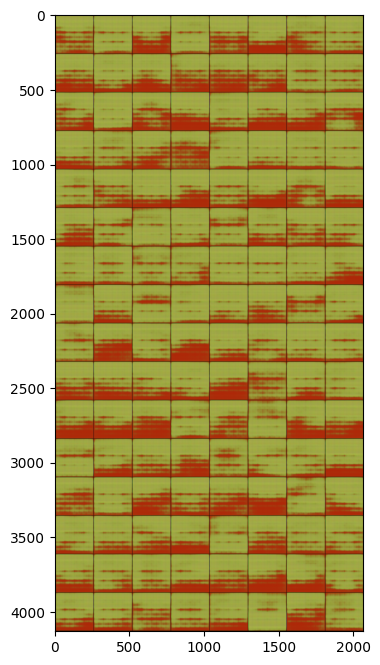

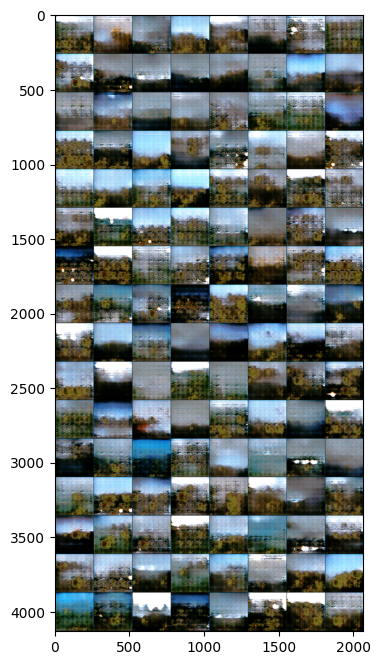

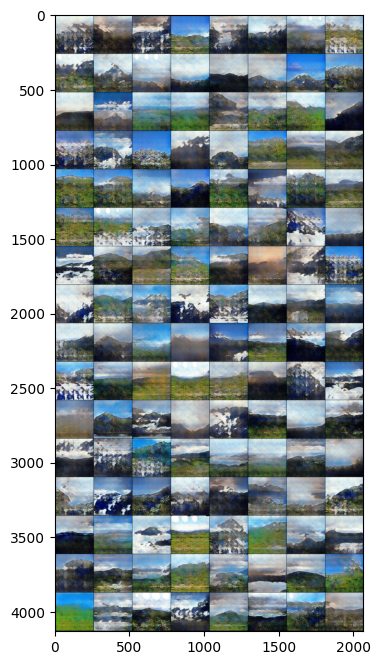

In [17]:
lr = 0.003
epochs = 200
history = fit(epochs, lr)

In [18]:
# save the model
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

## Useful link

__[Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)__

__[ConvTranspose2d](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html)__

__[Animation](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md)__